# Pipeline draft

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import run_dqn, run_ddpg, run_td3, run_td3_offline
from pmind.replay import (collect_policy_transitions, 
                          collect_uniform_transitions, 
                          mix_transitions, 
                          test_rb_compositions)

from pmind.config.loader import load_config

bbrl_utils.setup()

cfg = load_config("bbrl_example")

%load_ext autoreload
%autoreload 2

/Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
Using Python 3.10.18 environment at: /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv


In [2]:
# setup_tensorboard("./outputs/tblogs")

# Obtain transitions

In [3]:
ENV_NAME = ["CartPoleContinuous-v1","Pendulum-v1","MountainCarContinuous-v0","LunarLander-v3"][0]
BUFFER_SIZE = 100_000
PROPORTIONS = np.linspace(0,1,10)

## Best policy

Get the best policy and get transitions with it

In [4]:
cfg_td3_best = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_best.algorithm.max_epochs = 11_000
cfg_td3_best.algorithm.learning_starts = 1000

td3 = TD3(cfg_td3_best)
run_td3(td3)
td3.visualize_best()
best_policy_agent = td3.best_policy

Matplotlib backend: inline


  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/td3-S1_20260214-153100/best_agent


objc[30186]: Class SDLApplication is implemented in both /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x12bd50890) and /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1318892c8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[30186]: Class SDLAppDelegate is implemented in both /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x12bd508e0) and /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x131889318). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[30186]: Class SDLTranslatorResponder is implemented in both /Users/vlad/Documents/U

moviepy is not installed, skipping video display


In [5]:
rb_best = collect_policy_transitions(best_policy_agent ,ENV_NAME, buffer_size=BUFFER_SIZE)
print(f"Replay buffer with {rb_best.size()} transitions")

Replay buffer with 100000 transitions


## Uniform exploration

In [6]:
rb_unif = collect_uniform_transitions(ENV_NAME, buffer_size=BUFFER_SIZE)
print(f"Replay buffer with {rb_unif.size()} transitions")

Replay buffer with 100000 transitions


# Offline learning on mixed replay buffer

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

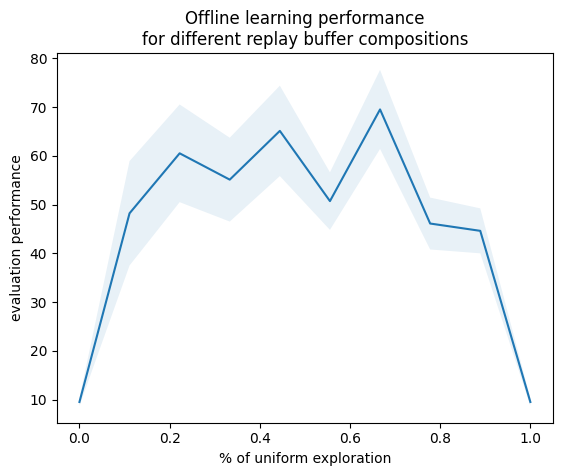

In [7]:
cfg_td3_offline = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000

# we don't care about when learning starts for offline:
cfg_td3_offline.algorithm.learning_starts = None

# TODO: apply no noise to actions during learning or it's independent? 
# cfg_td3_offline.action_noise = 0
# cfg_td3_offline.target_policy_noise = 0


perfs = test_rb_compositions(rb_unif=rb_unif, 
                    rb_best=rb_best,
                    buffer_size=BUFFER_SIZE,
                    proportions=PROPORTIONS,
                    agent_constructor=TD3,
                    cfg= cfg_td3_offline,
                    offline_run=run_td3_offline)